In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import os

file_name = 'ML_DataSet.txt'
if not os.path.exists(file_name):
    print(f"ERROR: Raw data file '{file_name}' not found in the current directory.")

    raise FileNotFoundError(f"Ensure '{file_name}' is in the same folder as this script/notebook.")

df = pd.read_csv(
    file_name,
    sep=';',
    index_col=0,
    parse_dates=True,
    decimal=',', 
    low_memory=False
)

df.index.name = 'timestamp'

print(f"Initial Shape: {df.shape}")
print(df.head())

Initial Shape: (140256, 370)
                     MT_001  MT_002  MT_003  MT_004  MT_005  MT_006  MT_007  \
timestamp                                                                     
2011-01-01 00:15:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 00:30:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 00:45:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 01:00:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 01:15:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

                     MT_008  MT_009  MT_010  ...  MT_361  MT_362  MT_363  \
timestamp                                    ...                           
2011-01-01 00:15:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2011-01-01 00:30:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2011-01-01 00:45:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2011-01-01 01:00:00     0.0     0.0  

In [3]:
load_col_original = df.columns[0] 
load_col_renamed = 'load'

df_load = df[[load_col_original]].copy()

df_load[load_col_renamed] = pd.to_numeric(df_load[load_col_original], errors='coerce')

df_load = df_load.drop(columns=[load_col_original]).rename(columns={load_col_renamed: 'load'})

print(f"\nNaNs after conversion for '{load_col_renamed}': {df_load['load'].isnull().sum()}")


NaNs after conversion for 'load': 0


In [4]:
import os

output_dir = 'data'

df_load = df_load.sort_index()

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

df_hourly = df_load.resample('h').sum()

df_hourly['load'] = df_hourly['load'].interpolate(method='time')

output_path = os.path.join(output_dir, 'industrial_load_hourly.parquet')
df_hourly.to_parquet(output_path, index=True)

print(f"\nFinal hourly data saved to: {output_path}")
print(f"Final Hourly Shape: {df_hourly.shape}")
print(df_hourly.head())



Final hourly data saved to: data\industrial_load_hourly.parquet
Final Hourly Shape: (35065, 1)
                     load
timestamp                
2011-01-01 00:00:00   0.0
2011-01-01 01:00:00   0.0
2011-01-01 02:00:00   0.0
2011-01-01 03:00:00   0.0
2011-01-01 04:00:00   0.0


In [7]:
import pandas as pd
import os

file_name = 'ML_DataSet.txt'
output_dir = '../data/'  
output_file = 'industrial_load_hourly.parquet'

if not os.path.exists(file_name):
    print(f"ERROR: Raw data file '{file_name}' not found in the current directory.")
    raise FileNotFoundError(f"Ensure '{file_name}' is in the folder: {os.getcwd()}")

df = pd.read_csv(
    file_name,
    sep=';',
    index_col=0,
    parse_dates=True,
    decimal=',',
    low_memory=False
)
df.index.name = 'timestamp'
print(f"Initial Shape: {df.shape}")

load_col_original = df.columns[0]
df_load = df[[load_col_original]].copy()
df_load['load'] = pd.to_numeric(df_load[load_col_original], errors='coerce')
df_load = df_load.drop(columns=[load_col_original])
df_load = df_load.sort_index()  

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created output directory: {os.path.abspath(output_dir)}")

df_hourly = df_load.resample('h').sum()
df_hourly['load'] = df_hourly['load'].interpolate(method='time')

output_path = os.path.join(output_dir, output_file)
df_hourly.to_parquet(output_path, index=True)

print(f"\nProcessed data saved successfully!")
print(f"File: {os.path.normpath(output_path)}")
print(f"Absolute Path: {os.path.abspath(output_path)}")
print(f"Final Hourly Shape: {df_hourly.shape}")


Initial Shape: (140256, 370)

Processed data saved successfully!
File: ..\data\industrial_load_hourly.parquet
Absolute Path: C:\Users\kumar\OneDrive\Desktop\College Project\ML\Project\data\industrial_load_hourly.parquet
Final Hourly Shape: (35065, 1)


📈 Phase 1: Data Loading and EDA
✅ Data loaded successfully. Total shape: (35065, 2)


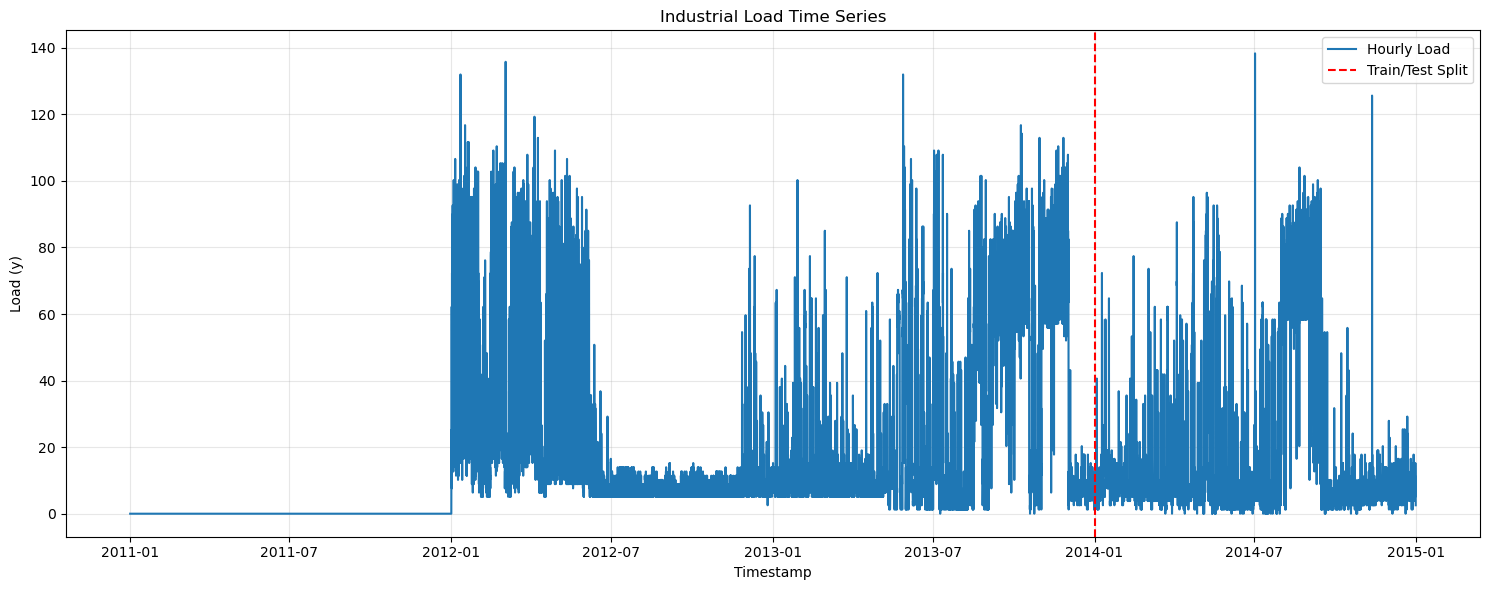

Training set size: 26304 samples
Testing set size: 8761 samples
✅ Phase 1 Complete: Data ready for Prophet baseline.


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

print("="*60)
print("📈 Phase 1: Data Loading and EDA")
print("="*60)

data_path = '../data/industrial_load_hourly.parquet'
split_date = pd.to_datetime('2014-01-01 00:00:00')

try:
    df_full = (
        pd.read_parquet(data_path)
        .reset_index()
        .rename(columns={'timestamp': 'ds', 'load': 'y'})
    )
    print(f" Data loaded successfully. Total shape: {df_full.shape}")
except FileNotFoundError:
    print(f" Data file not found at {data_path}. Creating mock data.")

    date_range = pd.date_range(start='2011-01-01', end='2014-06-01', freq='H')
    df_full = pd.DataFrame({'ds': date_range, 'y': np.sin(np.arange(len(date_range))/100) * 1000 + 10000 + np.random.randn(len(date_range)) * 50})
    df_full['y'] = df_full['y'].apply(lambda x: max(0, x)) # Ensure positive
    print(f" Using mock data for demonstration.")

plt.figure(figsize=(15, 6))
plt.plot(df_full['ds'], df_full['y'], label='Hourly Load')
plt.axvline(split_date, color='red', linestyle='--', label='Train/Test Split')
plt.title('Industrial Load Time Series')
plt.xlabel('Timestamp')
plt.ylabel('Load (y)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

df_train = df_full[df_full['ds'] < split_date].copy()
df_test = df_full[df_full['ds'] >= split_date].copy()

print(f"Training set size: {df_train.shape[0]} samples")
print(f"Testing set size: {df_test.shape[0]} samples")

print("="*60)
print("✅ Phase 1 Complete: Data ready for Prophet baseline.")
print("="*60)
